This is a simple demo in the use of a GNN. There is a minimal dataset and GNN implementation included.

In [1]:
import torch
import torch.nn as nn
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
import numpy as np

In [2]:
import mplhep as mh
mh.style.use("CMS") 

In [3]:
from me0.data.datasets.GNNDataset import GNNDataset
from me0.modules.gnn.model import HitGNN

In [4]:
dataset = GNNDataset("preprocessed_graph", d_strip_max=10, d_ieta_max=2, d_bx_max=1)

In [5]:
# Note, I changed this to be mps for testing on my laptop, you should use CUDA for any non-mac silicone devices
device = torch.device('mps' if torch.mps.is_available() else 'cpu')

model = HitGNN(input_node_dim=5, edge_dim=5, hidden_dim=16, num_layers=6).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=0)

loss_fn = nn.BCEWithLogitsLoss(pos_weight=torch.tensor(75))

In [6]:
# A quick and dirty function to count the parameters of the model
def count_parameters(model):
    return sum(p.numel() for p in model.parameters())

total_params = count_parameters(model)
print(f"Total parameters: {total_params}")

Total parameters: 35095


In [7]:
from torch_geometric.loader import DataLoader
from torch.utils.data import Subset

n_train = 10000
n_val = 10000

train_subset =  Subset(dataset, list(range(0, n_train)))
val_subset = Subset(dataset, list(range(n_train, n_train+n_val)))

train_loader = DataLoader(train_subset,  shuffle=True, drop_last=True, batch_size=100)
val_loader = DataLoader(val_subset, shuffle=False, drop_last=True, batch_size=100)


In [8]:
def train_loop(epoch, step, out_df):
    for batch in tqdm(train_loader):
        batch = batch.to('mps')
        optimizer.zero_grad()
        out = model(batch)
        loss = loss_fn(out, batch.y.float().squeeze())
        loss.backward()
        optimizer.step()
        out_df.loc[len(out_df)] = [epoch, step, loss.item(), None]
        step += 1
    return step

In [9]:
def val_loop(epoch, step, out_df):
    groundtruth = []
    likelihood = []
    with torch.inference_mode():
        loss = 0
        for batch in tqdm(val_loader):
            batch = batch.to('mps')
            out = model(batch)
            loss += loss_fn(out, batch.y.float().squeeze()).item()
            # Save predictions
            groundtruth += (batch.y.squeeze()==1).cpu().tolist()
            likelihood += nn.functional.sigmoid(out).cpu().tolist()
        groundtruth = np.array(groundtruth)
        likelihood = np.array(likelihood) 
        out_df.loc[len(out_df)] = [epoch, step, None, loss/len(val_loader)]
        return groundtruth, likelihood

In [10]:
out_df = pd.DataFrame(columns=['epoch', 'step', 'train_loss', 'val_loss'])

num_epoch = 5
step = 0
epoch = 0

groundtruth, likelihood = val_loop(epoch, step, out_df)

for epoch in range(num_epoch+1):
    step = train_loop(epoch, step, out_df)
    groundtruth, likelihood = val_loop(epoch, step, out_df)
    print(f"""
    Epoch {epoch}/{num_epoch}
        train_loss: {out_df[(out_df['epoch'] == epoch)]['train_loss'].dropna().mean()}
        val_loss: {out_df[(out_df['epoch'] == epoch)]['val_loss'].dropna().mean()}
    """) 

100%|██████████| 100/100 [00:01<00:00, 85.85it/s]



    Epoch 0/5
        train_loss: 0.3653007610142231
        val_loss: 0.7523128991760314
    


100%|██████████| 100/100 [00:01<00:00, 78.30it/s]



    Epoch 1/5
        train_loss: 0.09720509130507708
        val_loss: 0.09864550672471523
    


100%|██████████| 100/100 [00:01<00:00, 70.06it/s]



    Epoch 2/5
        train_loss: 0.10434373293071986
        val_loss: 0.08577145490795374
    


100%|██████████| 100/100 [00:01<00:00, 77.32it/s]



    Epoch 3/5
        train_loss: 0.09962144490331411
        val_loss: 0.09235759750008583
    


100%|██████████| 100/100 [00:01<00:00, 65.38it/s]



    Epoch 4/5
        train_loss: 0.0906083558872342
        val_loss: 0.08826120890676975
    


100%|██████████| 100/100 [00:01<00:00, 63.43it/s]


    Epoch 5/5
        train_loss: 0.08429138273000718
        val_loss: 0.09369501676410437
    


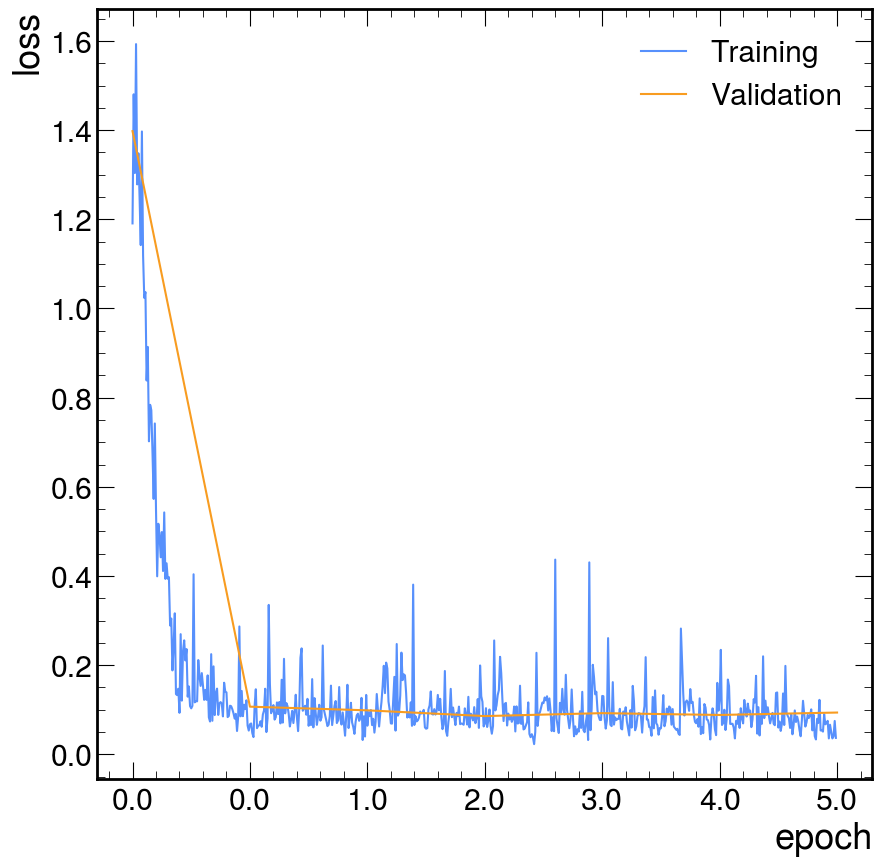

In [11]:

plt.plot(out_df[out_df['train_loss'].notna()]['step'], out_df['train_loss'].dropna(), label='Training')
plt.plot(out_df[out_df['val_loss'].notna()]['step'], out_df['val_loss'].dropna(), label='Validation')
plt.xticks(ticks=out_df[out_df['val_loss'].notna()]['step'], labels=out_df[out_df['val_loss'].notna()]['epoch'])
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend()

(0.001, 30.0)

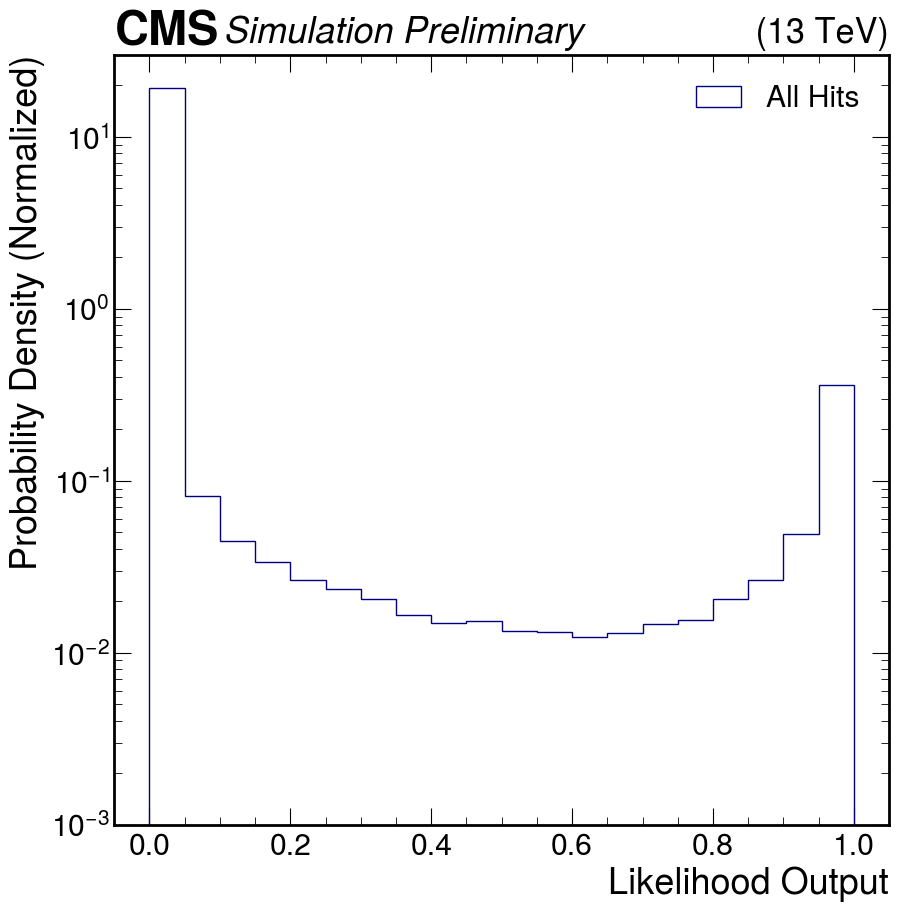

In [21]:
# Now, you have two arrays of data.
# Likelihood contains the model's output probability for each hit
bins = np.linspace(0, 1, 21)
fig, ax = plt.subplots(figsize=(10, 10))
plt.hist(
        likelihood, 
        bins=bins, 
        density=True, 
        label='All Hits',
        histtype='step',
        color='navy'
    )
plt.yscale('log')
plt.legend()
plt.xlabel('Likelihood Output')
plt.ylabel('Probability Density (Normalized)')
mh.cms.label(loc=0, label="Preliminary", data=False) 

plt.ylim(1e-3, 3e1) 



/opt/homebrew/Caskroom/miniconda/base/envs/ME0/lib/python3.11/site-packages/matplotlib/axes/_axes.py:7132: RuntimeWarning: Converting input from bool to <class 'numpy.uint8'> for compatibility.
  m, bins = np.histogram(x[i], bins, weights=w[i], **hist_kwargs)


(0.001, 30.0)

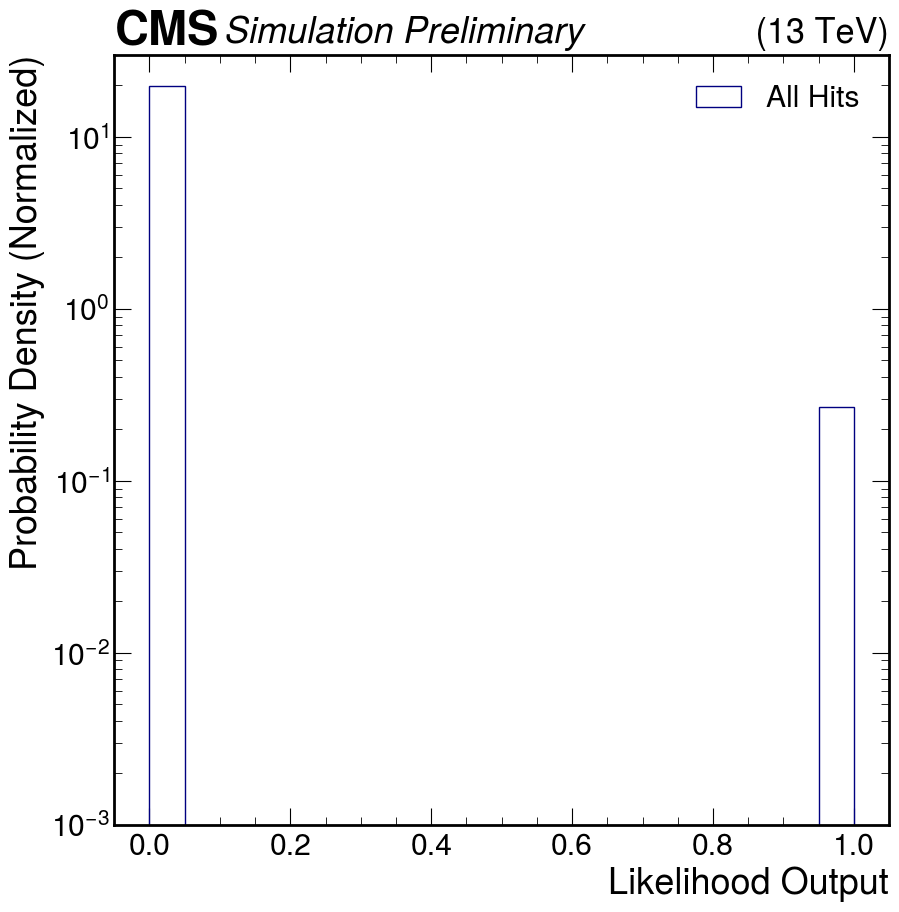

In [ ]:
# Groundtruth contains the mc truth of if the hit is a muon or not. 
bins = np.linspace(0, 1, 21)
fig, ax = plt.subplots(figsize=(10, 10))
plt.hist(
        groundtruth, 
        bins=bins, 
        density=True, 
        label='All Hits',
        histtype='step',
        color='navy'
    )
plt.yscale('log')
plt.legend()
plt.xlabel('Ground Truth')
plt.ylabel('Probability Density (Normalized)')
mh.cms.label(loc=0, label="Preliminary", data=False) 

plt.ylim(1e-3, 3e1) 



(0.001, 30.0)

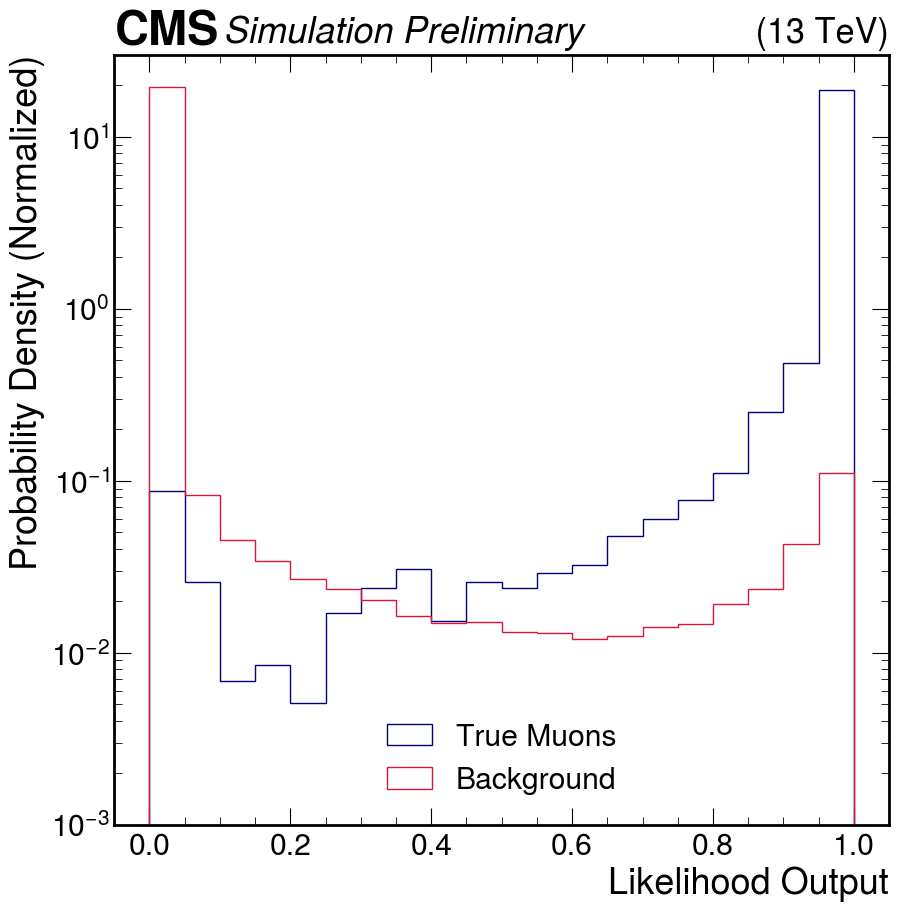

In [12]:
bins = np.linspace(0, 1, 21)
fig, ax = plt.subplots(figsize=(10, 10))
plt.hist(
        likelihood[groundtruth], 
        bins=bins, 
        density=True, 
        label='True Muons',
        histtype='step',
        color='navy'
    )
plt.hist(
        likelihood[(~groundtruth)], 
        bins=bins, 
        density=True, 
        label='Background',
        histtype='step',
        color='crimson'
    )
plt.yscale('log')
plt.legend()
plt.xlabel('Likelihood Output')
plt.ylabel('Probability Density (Normalized)')
# plt.title('Distribution of Model Outputs', fontsize=14)
mh.cms.label(loc=0, label="Preliminary", data=False) 

plt.ylim(1e-3, 3e1) 


In [13]:
def compute_tpr_fpr(groundtruth, likelihood, cutoff):
    mask = groundtruth == 1
    n_muons = mask.sum()
    n_non_muons = (1-mask).sum()

    tp = (likelihood[groundtruth] >= cutoff).sum()
    tpr = tp/n_muons

    fp = (likelihood[~groundtruth] >= cutoff).sum()
    fpr = fp / n_non_muons
    return tpr, fpr
# Compute the true positive rate and false positve rate for a cutoff of .5 in the likelihood
compute_tpr_fpr(groundtruth, likelihood, .5)

(np.float64(0.9877248316426562), np.float64(0.013802770715125316))

In [14]:
# Compute tpr and fpr for various cutoffs
cutoffs = np.linspace(0, 1, 1000)
tprs = []
fprs = []
for cutoff in cutoffs:
    tpr, fpr = compute_tpr_fpr(groundtruth, likelihood, cutoff)
    tprs.append(tpr)
    fprs.append(fpr)

tprs = np.array(tprs)
fprs = np.array(fprs)

In [15]:
def fpr_at_tpr(target_tpr):
    # Compute FPR at fixed TPR in a simple way. Accurate enough as long as the cutoffs are high resolution.
    diff = np.abs(tprs-target_tpr)
    idx = np.where(diff==diff.min())
    return cutoffs[idx][0], fprs[idx][0], tprs[idx][0]

0.9779779779779779 0.004126744398181184 0.8997527917483591
0.9169169169169169 0.007058418720224281 0.9499616400988833
0.062062062062062065 0.026409316697034148 0.995055834967181


(exptext: Custom Text(0.001, 1, 'CMS'),
 expsuffix: Custom Text(0.001, 1.005, 'Simulation Preliminary'),
 supptext: Custom Text(1.012, 1, ''))

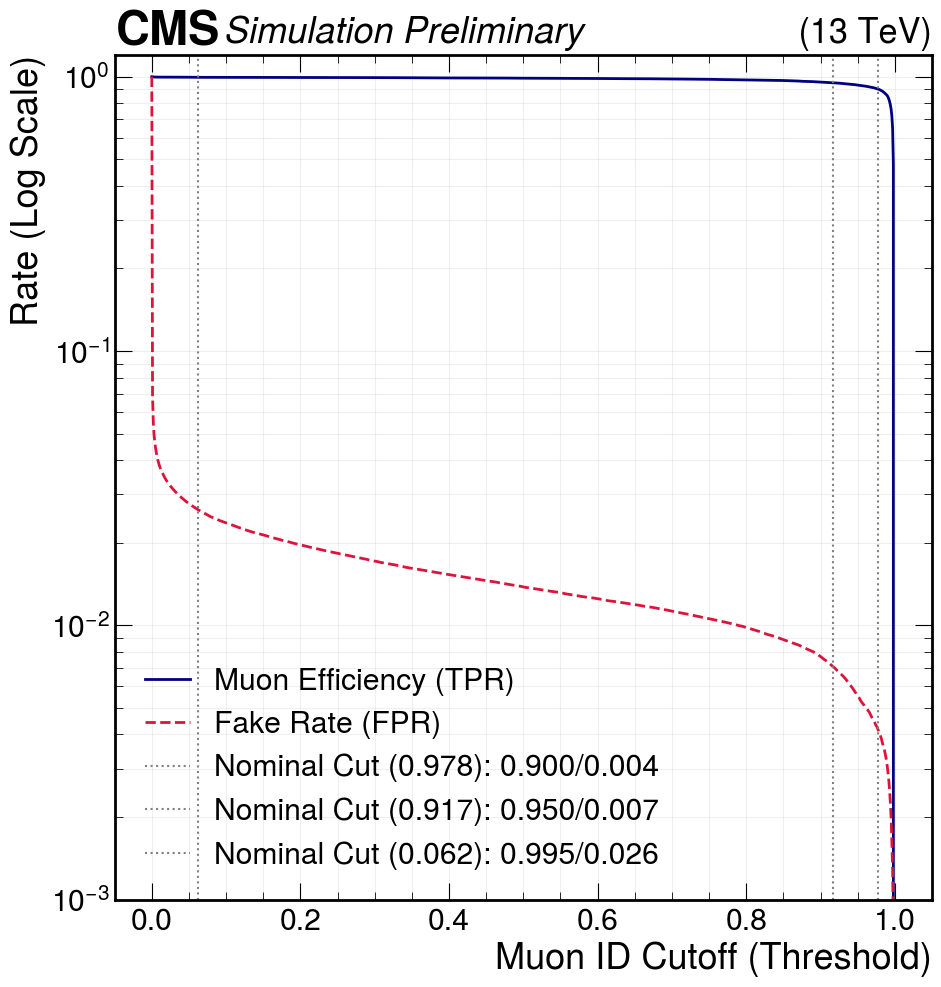

In [16]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))

plt.plot(cutoffs, tprs, label="Muon Efficiency (TPR)", color='navy', lw=2)
plt.plot(cutoffs, fprs, label="Fake Rate (FPR)", color='crimson', lw=2, linestyle='--')

plt.yscale('log')
plt.ylim(1e-3, 1.2) 

plt.xlabel('Muon ID Cutoff (Threshold)')
plt.ylabel('Rate (Log Scale)')

plt.grid(True, which="both", ls="-", alpha=0.2)

target_tprs = [0.9, 0.95, 0.995]
for tpr in target_tprs:
    cut, fpr, tpr = fpr_at_tpr(tpr)
    print(cut, fpr, tpr)
    # tpr, fpr = compute_tpr_fpr(groundtruth, likelihood, cut)
    plt.axvline(x=cut, color='gray', linestyle=':', label=f'Nominal Cut ({cut:.3f}): {tpr:.3f}/{fpr:.3f}')

plt.legend(frameon=False, loc='lower left')
plt.tight_layout()
mh.cms.label(loc=0, label="Preliminary", data=False) 

(exptext: Custom Text(0.0, 1, 'CMS'),
 expsuffix: Custom Text(0.0, 1.005, 'Simulation Preliminary'),
 supptext: Custom Text(1.012, 1, ''))

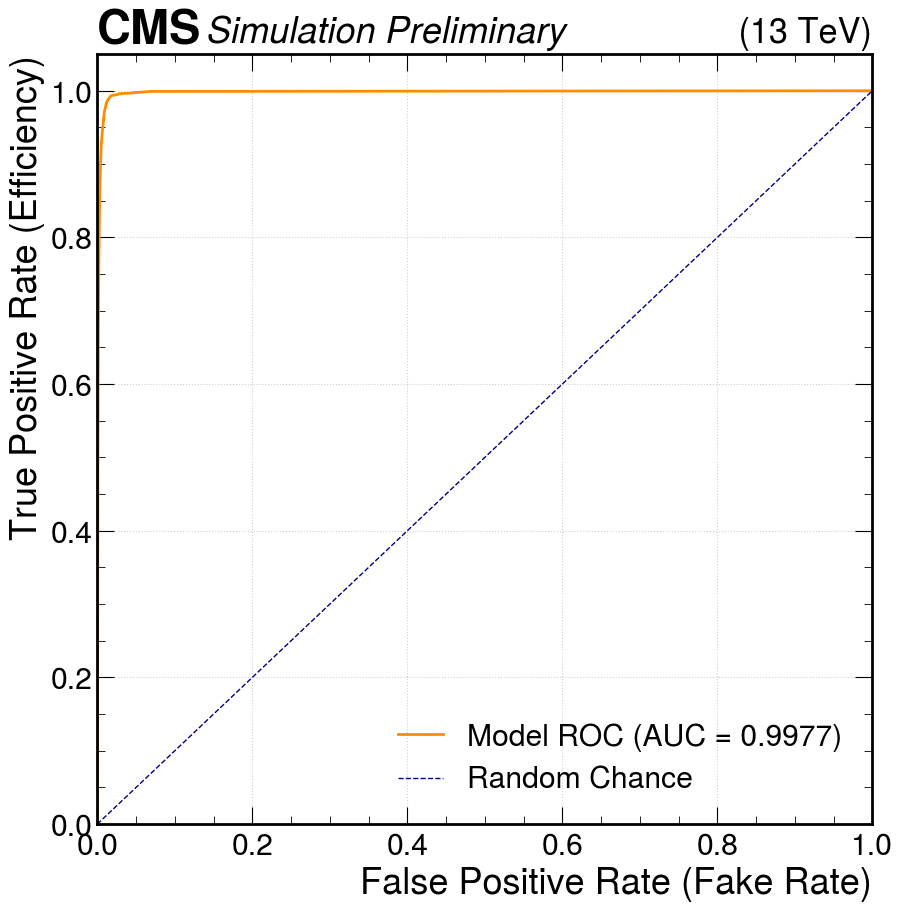

In [17]:
import matplotlib.pyplot as plt
import numpy as np

plt.figure(figsize=(10, 10))

auc_score = np.abs(np.trapezoid(tprs, fprs))

plt.plot(fprs, tprs, color='darkorange', lw=2, 
         label=f'Model ROC (AUC = {auc_score:.4f})')

plt.plot([0, 1], [0, 1], color='navy', lw=1, linestyle='--', label='Random Chance')

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05]) 
plt.xlabel('False Positive Rate (Fake Rate)')
plt.ylabel('True Positive Rate (Efficiency)')

plt.grid(True, linestyle=':', alpha=0.6)
plt.legend(loc="lower right", frameon=False)
mh.cms.label(loc=0, label="Preliminary", data=False) 